<a href="https://colab.research.google.com/github/jai-llm/TEXT2SQL/blob/main/2c_Text2SQL_Compare_ROGUEv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2c. ROGUE Scores Llama2 vs LLama2 Fine-Tuned

In [120]:
# !pip install -r rouge/requirements.txt
!pip install -q -U rouge-score
!pip install -q -U "git+https://github.com/pltrdy/rouge"

  Preparing metadata (setup.py) ... done


### Imports

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import os
# import time
# import json


from rouge import Rouge
from rouge_score import rouge_scorer
# from time import perf_counter

### Check ROGUE_Scorer Package

In [122]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
print(scores)
display(pd.DataFrame(scores))

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765), 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666), 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}


,rouge1,rouge2,rougeL
0,0.750000,0.285714,0.625000
1,0.666667,0.250000,0.555556
2,0.705882,0.266667,0.588235


### Check ROGUE Package

In [123]:
hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
display(pd.DataFrame(scores))

,rouge-1,rouge-2,rouge-l
0,"{'r': 0.42857142857142855, 'p': 0.583333333333...","{'r': 0.18571428571428572, 'p': 0.317073170731...","{'r': 0.3877551020408163, 'p': 0.5277777777777..."


### Global Constants

In [124]:
# GDrive Location for Train/Test Data
DATA_PATH ="/content/drive/MyDrive/Text2SQL/Data/"
DS_DIR = "sql_train_test"
PKL_DIR = "test/"
PKL_FILE ="sql_test.pkl"
LLAMA_PKL_FILE="sql_test_Llama2.pkl"
LLMRES_PKL_FILE="sql_test_llmres.pkl"

# Results
RES_PATH="/content/drive/MyDrive/Text2SQL/Results/"
LLAMA_RES_FILE="llama_rogue.csv"
FINETUNE_RES_FILE="finetune_rogue.csv"

# Fig Constants
FIG_PATH="/content/drive/MyDrive/Text2SQL/Figs/"
FIG_NAME="ROGUE_Scores_Llama_vs_Finetune.png"

### Common Functions

In [125]:
def compute_rogue(df):
  '''Computes Avg ROGUE Scores: ROGUE-1,2,L and returns results as Dataframe'''
  rouge = Rouge()

  # Convert to List
  df_res = df['eval_res'].tolist()
  df_ref = df['response'].tolist()

  # Get Rogue-1, Rogue-2, Rogue-L as dict
  rogue_dict = rouge.get_scores(df_res, df_ref, avg=True)

  # Convert Dict to DataFrame
  rogue_df = pd.DataFrame(rogue_dict)

  return rogue_df

In [126]:
def create_plt_df(df, index_names=['metric', 'type'], column_names=['llama2']):
  plt_df = pd.DataFrame(df.unstack(), columns=column_names)
  plt_df.reset_index(names=index_names, inplace=True)
  plt_df[index_names[1]] = plt_df[index_names[1]].map({'r': 'Recall', 'p':'Precision', 'f':'F1-Score'})
  return plt_df

### Read in Evaluation Files

In [127]:
llama_df=pd.read_pickle(DATA_PATH + PKL_DIR + LLAMA_PKL_FILE)
display(llama_df.head(2))

,question,context,response,__index_level_0__,text,eval_res,eval_time
0,Show the name of track and the number of races...,"CREATE TABLE track (name VARCHAR, track_id VAR...","SELECT T2.name, COUNT(*) FROM race AS T1 JOIN ...",429,### Instruction:\n You are a powerful text-...,1. SELECT COUNT(*) FROM race WHERE track_id = ...,5.904698
1,Show names of shops and the carriers of device...,"CREATE TABLE shop (Shop_Name VARCHAR, Shop_ID ...","SELECT T3.Shop_Name, T2.Carrier FROM stock AS ...",2907,### Instruction:\n You are a powerful text-...,"SELECT s1.shop_name AS 'Shop Name',s2.stock_id...",6.355793


In [128]:
finetune_df = pd.read_pickle(DATA_PATH + PKL_DIR + LLMRES_PKL_FILE)
display(finetune_df.head(2))

,question,context,response,__index_level_0__,text,eval_res,eval_time
0,Show the name of track and the number of races...,"CREATE TABLE track (name VARCHAR, track_id VAR...","SELECT T2.name, COUNT(*) FROM race AS T1 JOIN ...",429,### Instruction:\n You are a powerful text-...,"SELECT T1.name, COUNT(*) FROM track AS T1 JOIN...",3.763995
1,Show names of shops and the carriers of device...,"CREATE TABLE shop (Shop_Name VARCHAR, Shop_ID ...","SELECT T3.Shop_Name, T2.Carrier FROM stock AS ...",2907,### Instruction:\n You are a powerful text-...,SELECT T1.Shop_name FROM stock AS T2 JOIN shop...,8.575436


### LLama SQL Responses are Not Good But ... Fine Tuned Results are Correct

In [129]:
llama_df['response'][4]

'SELECT LOCATION FROM cinema WHERE capacity > 300 GROUP BY LOCATION HAVING COUNT(*) > 1'

In [130]:
llama_df['eval_res'][4]

"1 location has more than one movie theatre with capacity over 300\n        SELECT * FROM cinema WHERE LOCATION = 'New York' AND capacity > 300;\n\\end{code}"

In [131]:
finetune_df['eval_res'][4]

'SELECT LOCATION FROM cinema WHERE capacity > 300 GROUP BY LOCATION HAVING COUNT(*) >= 2'

### Llama2 ROGUE Score
r-Recall; p-Precision; f-F1 Score

In [132]:
llama_rogue = compute_rogue(df=llama_df)
display(llama_rogue)

,rouge-1,rouge-2,rouge-l
r,0.432155,0.197478,0.418971
p,0.284167,0.124175,0.275835
f,0.325152,0.143906,0.315660


In [133]:
llama_rogue.to_csv(RES_PATH + LLAMA_RES_FILE)

In [134]:
l2_rogue = create_plt_df(llama_rogue, index_names=['metric', 'type'], column_names=['llama2'])
display(l2_rogue)

,metric,type,llama2
0,rouge-1,Recall,0.432155
1,rouge-1,Precision,0.284167
2,rouge-1,F1-Score,0.325152
3,rouge-2,Recall,0.197478
4,rouge-2,Precision,0.124175
5,rouge-2,F1-Score,0.143906
6,rouge-l,Recall,0.418971
7,rouge-l,Precision,0.275835
8,rouge-l,F1-Score,0.315660


### Llama2 Fine-Tune ROGUE Score
r-Recall; p-Precision; f-F1 Score

In [135]:
finetune_rogue = compute_rogue(df=finetune_df)
display(finetune_rogue)

,rouge-1,rouge-2,rouge-l
r,0.873064,0.636062,0.852292
p,0.740200,0.557483,0.723304
f,0.786445,0.580282,0.768057


In [136]:
finetune_rogue.to_csv(RES_PATH + FINETUNE_RES_FILE)

In [137]:
ft_rogue = create_plt_df(finetune_rogue, index_names=['metric', 'type'], column_names=['finetuned'])
display(ft_rogue)

,metric,type,finetuned
0,rouge-1,Recall,0.873064
1,rouge-1,Precision,0.740200
2,rouge-1,F1-Score,0.786445
3,rouge-2,Recall,0.636062
4,rouge-2,Precision,0.557483
5,rouge-2,F1-Score,0.580282
6,rouge-l,Recall,0.852292
7,rouge-l,Precision,0.723304
8,rouge-l,F1-Score,0.768057


### Plot ROGUE Results

In [138]:
l2_ft_rogue = l2_rogue.merge(ft_rogue, on=['metric', 'type'], how='inner')
display(l2_ft_rogue)

,metric,type,llama2,finetuned
0,rouge-1,Recall,0.432155,0.873064
1,rouge-1,Precision,0.284167,0.740200
2,rouge-1,F1-Score,0.325152,0.786445
3,rouge-2,Recall,0.197478,0.636062
4,rouge-2,Precision,0.124175,0.557483
5,rouge-2,F1-Score,0.143906,0.580282
6,rouge-l,Recall,0.418971,0.852292
7,rouge-l,Precision,0.275835,0.723304
8,rouge-l,F1-Score,0.315660,0.768057


In [139]:
l2_ft_rogue_plt = l2_ft_rogue.melt(id_vars=['metric','type'], value_vars=['llama2','finetuned'],
                                   var_name='model', value_name='score'
                                   )
display(l2_ft_rogue_plt)

,metric,type,model,score
0,rouge-1,Recall,llama2,0.432155
1,rouge-1,Precision,llama2,0.284167
2,rouge-1,F1-Score,llama2,0.325152
3,rouge-2,Recall,llama2,0.197478
4,rouge-2,Precision,llama2,0.124175
5,rouge-2,F1-Score,llama2,0.143906
6,rouge-l,Recall,llama2,0.418971
7,rouge-l,Precision,llama2,0.275835
8,rouge-l,F1-Score,llama2,0.315660
9,rouge-1,Recall,finetuned,0.873064


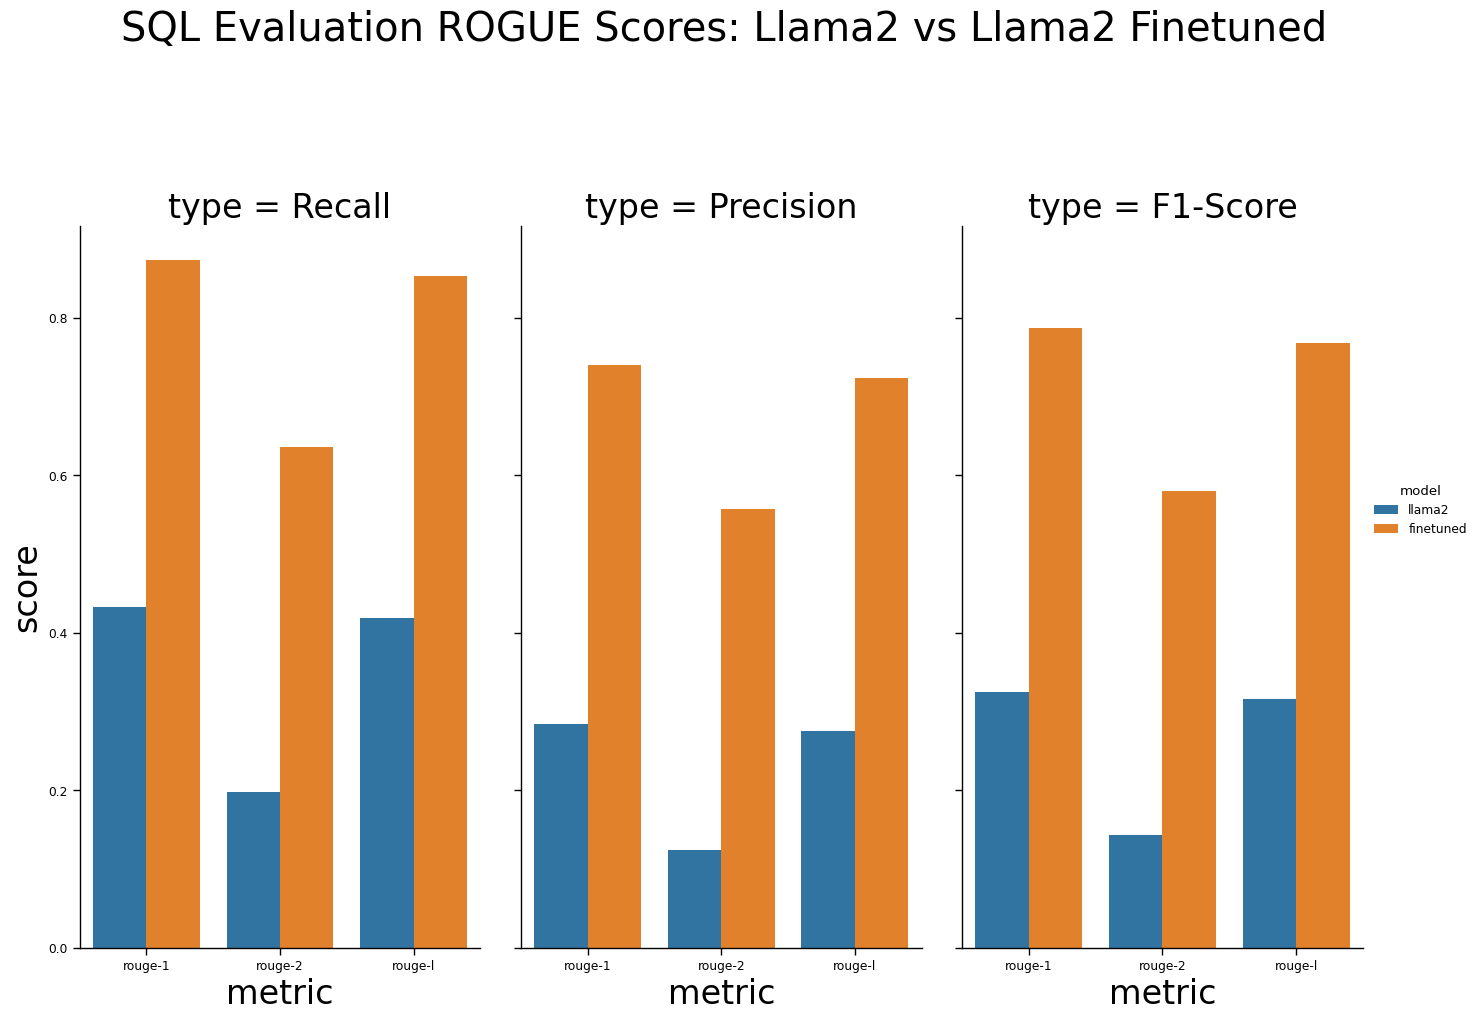

In [140]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":30,"axes.labelsize":24})
cat = sns.catplot(x='metric',y='score', hue='model', col='type', kind='bar',
                  data=l2_ft_rogue_plt) #, height=15, aspect=0.5)
cat.fig.subplots_adjust(top=.8)
cat.fig.suptitle('SQL Evaluation ROGUE Scores: Llama2 vs Llama2 Finetuned')
cat.fig.set_size_inches(15, 12)

plt.savefig(FIG_PATH+FIG_NAME) # Goto save before show
plt.show()